# LayoutXLM to onnx

In [2]:
from transformers import LayoutLMv2ForTokenClassification
from transformers import LayoutXLMProcessor

import torch
import warnings
import contextlib

import requests
from urllib3.exceptions import InsecureRequestWarning

old_merge_environment_settings = requests.Session.merge_environment_settings

@contextlib.contextmanager
def no_ssl_verification():
    opened_adapters = set()

    def merge_environment_settings(self, url, proxies, stream, verify, cert):
        # Verification happens only once per connection so we need to close
        # all the opened adapters once we're done. Otherwise, the effects of
        # verify=False persist beyond the end of this context manager.
        opened_adapters.add(self.get_adapter(url))

        settings = old_merge_environment_settings(self, url, proxies, stream, verify, cert)
        settings['verify'] = False

        return settings

    requests.Session.merge_environment_settings = merge_environment_settings

    try:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', InsecureRequestWarning)
            yield
    finally:
        requests.Session.merge_environment_settings = old_merge_environment_settings

        for adapter in opened_adapters:
            try:
                adapter.close()
            except:
                pass

with no_ssl_verification():
    processor = LayoutXLMProcessor.from_pretrained("/home/vshishaev/layout_all/layout_checks/layoutXLM_sroie_rus_ordered_2506", apply_ocr=False)

device = torch.device('cpu')
clf_model = LayoutLMv2ForTokenClassification.from_pretrained("/home/vshishaev/layout_all/layout_checks/layoutXLM_sroie_rus_ordered_2506")

In [2]:
# test X data
import numpy as np
from datasets import load_from_disk

val_receipts = load_from_disk('/home/vshishaev/layout_all/receipts_validation_after_procsr')
val_receipts.set_format('torch')

clf_model.to(device)
encoding = val_receipts[9]

for k,v in encoding.items():
  encoding[k] = v.unsqueeze(0).to(device)

clf_model.eval()
# forward pass
outputs = clf_model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'],
                bbox=encoding['bbox'], image=encoding['image'])

# print(outputs.logits.shape)
labels = outputs.logits.argmax(-1).cpu().numpy().squeeze(0)
# print(labels)

In [4]:
# maybe one day I will write a proper func for inference..

X = (encoding['input_ids'], encoding['bbox'], encoding['image'], encoding['attention_mask'])
X_layout_onnx = {}

for k, v in encoding.items():
    X_layout_onnx[k] = np.array(v.cpu())
    for i, x in enumerate(v):
        X_layout_onnx[k][i] = np.array(x.cpu()).astype(np.int64)

In [4]:
import numpy as np

from torch import nn
import torch.utils.model_zoo as model_zoo
import torch.onnx

clf_model.eval()

# Export the model
torch.onnx.export(clf_model,               # model being run
                  X,                         # model input (or a tuple for multiple inputs)
                  "/home/vshishaev/layout_all/layoutXLM_2506.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=12,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input_ids', 'bbox', 'image', 'attention_mask'], # the model's 
                  output_names = ['outputs'], # the model's output names
                  )

# free

/home/vshishaev/anaconda3/envs/big_chungus/lib/python3.9/site-packages/detectron2/layers/wrappers.py:100: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.numel() == 0 and self.training:


============ Diagnostic Run torch.onnx.export version 2.0.0.post200 ============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [6]:
# wasting of time trying to convert layoutxlm using custom api config sheesh
# converting with pytorch works just fine

# class LayoutLMv2OnnxConfig(TextAndVisionOnnxConfig):
#     MIN_TORCH_VERSION = version.parse("1.12")
#     NORMALIZED_CONFIG_CLASS = NormalizedTextConfig.with_args(
#         allow_new=True,
#         MAX_2D_POSITION_EMBEDDINGS="max_2d_position_embeddings",
#         image_size="input_size",
#     )
#     DEFAULT_ONNX_OPSET = 12

#     @property
#     def inputs(self) -> Dict[str, Dict[int, str]]:
#         if self.task in ["token-classification", "question-answering"]:
#             pixel_values_dynamic_axes = {0: "batch_size", 1: "num_channels", 2: "height", 3: "width"}
#         else:
#             pixel_values_dynamic_axes = {0: "batch_size", 1: "num_channels"}
#         return {
#             "input_ids": {0: "batch_size", 1: "sequence_length"},
#             "attention_mask": {0: "batch_size", 1: "sequence_length"},
#             "bbox": {0: "batch_size", 1: "sequence_length"},
#             "image": pixel_values_dynamic_axes,
#         }

# "layoutlmv2": supported_tasks_mapping(
#             "feature-extraction",
#             "question-answering",
#             "text-classification",
#             "token-classification",
#             onnx="LayoutXLMOnnxConfig",
#         ),
#
# also added new supporting name "image" for DummyVisionGenerator in utils/input_generators.py

# from transformers import AutoConfig
# from optimum.exporters.onnx.model_configs import LayoutLMv2OnnxConfig

# config = AutoConfig.from_pretrained("/home/vshishaev/layout_all/layout_checks/layoutXLM_sroie_rus_ordered_0506")
# onnx_config = LayoutLMv2OnnxConfig(config)
# print(onnx_config.DEFAULT_ONNX_OPSET)
# print(onnx_config.outputs)

# config = AutoConfig.from_pretrained("/home/vshishaev/layout_all/layout_checks/layoutXLM_sroie_rus_ordered_0506")
# onnx_config_for_seq_clf = LayoutLMv2OnnxConfig(config, task="token-classification")
# print(onnx_config_for_seq_clf.inputs)
# print(onnx_config_for_seq_clf.outputs)

# from pathlib import Path
# from optimum.exporters import TasksManager
# from optimum.exporters.onnx import export
# from transformers import LayoutLMv2ForTokenClassification

# base_model = LayoutLMv2ForTokenClassification.from_pretrained("/home/vshishaev/layout_all/layout_checks/layoutXLM_sroie_rus_ordered_0506")

# onnx_path = Path("/home/vshishaev/layout_all/layout_xlm.onnx")
# onnx_config_constructor = TasksManager.get_exporter_config_constructor("onnx", base_model, task='token-classification')
# onnx_config = onnx_config_constructor(base_model.config)

# onnx_inputs, onnx_outputs = export(base_model, onnx_config, onnx_path, onnx_config.DEFAULT_ONNX_OPSET)

In [8]:
import onnx, onnxruntime

layout_model_name = '/home/vshishaev/layout_all/layoutXLM_2506.onnx'
layout_onnx_model = onnx.load(layout_model_name)
onnx.checker.check_model(layout_onnx_model)

EP_list = ['CPUExecutionProvider']

ort_session = onnxruntime.InferenceSession(layout_onnx_model.SerializeToString(), providers=EP_list)

In [9]:
# X = (encoding['input_ids'], encoding['bbox'], encoding['image'], encoding['attention_mask'])

input_name = ort_session.get_inputs()
label_name = ort_session.get_outputs()[0].name

for input in input_name:
    print(input)

pred_onnx = ort_session.run([label_name], {
    input_name[0].name: X_onnx['input_ids'],
    input_name[1].name: X_onnx['bbox'],
    input_name[2].name: X_onnx['image'],
    input_name[3].name: X_onnx['attention_mask'],
})

# check that transformer inference is identical to onnx inference
pred_labels = np.array(pred_onnx).argmax(-1).squeeze(0)[0]
if all(labels == pred_labels):
    print('Yey')

NodeArg(name='input_ids', type='tensor(int64)', shape=[1, 512])
NodeArg(name='bbox', type='tensor(int64)', shape=[1, 512, 4])
NodeArg(name='image', type='tensor(int64)', shape=[1, 3, 224, 224])
NodeArg(name='attention_mask', type='tensor(int64)', shape=[1, 512])
Yey


# Detector to onnx

In [3]:
detection_model_weights = '/home/vshishaev/ocr_engine/docbank_all_0607.pt'
detection_model = torch.hub.load('/home/vshishaev/ocr_engine/yolov5', 'custom', path=detection_model_weights, source='local') 
X_detector = torch.randn(1, 3, 1024, 1024)
detection_model.to(torch.device('cpu'))
detection_model.eval();


WARNING ⚠️ torchvision==0.10 is incompatible with torch==2.0.
Run 'pip install torchvision==0.15' to fix torchvision or 'pip install -U torch torchvision' to update both.
For a full compatibility table see https://github.com/pytorch/vision#installation
requirements: Ultralytics requirement ['requests>=2.32.0'] not found, attempting AutoUpdate...
Defaulting to user installation because normal site-packages is not writeable

requirements: AutoUpdate success ✅ 1.1s, installed 1 package: ['requests>=2.32.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



YOLOv5 🚀 v7.0-333-gb9019671 Python-3.9.19 torch-2.0.0.post200 CUDA:0 (NVIDIA GeForce RTX 3060, 12044MiB)

Fusing layers... 
YOLOv5m summary: 212 layers, 20877180 parameters, 0 gradients
Adding AutoShape... 


In [4]:
import torch.onnx


# Export the model
torch.onnx.export(detection_model,  # model being run
                  X_detector,       # model input (or a tuple for multiple inputs)
                  "/home/vshishaev/ocr_engine/docbank_all_0607.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=12,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['image'], # the model's input names
                  output_names = ['boxes'], # the model's output names
                  )

/home/vshishaev/ocr_engine/yolov5/models/common.py:666: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  y = self.model(im, augment=augment, visualize=visualize) if augment or visualize else self.model(im)
/home/vshishaev/ocr_engine/yolov5/models/yolo.py:100: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.dynamic or self.grid[i].shape[2:4] != x[i].shape[2:4]:


============ Diagnostic Run torch.onnx.export version 2.0.0.post200 ============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



# MCRNN to onnx

In [5]:
from torch import nn
import torch.onnx
import numpy as np

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, pool_ksize=(2, 2)):
        super(ConvBlock, self).__init__()

        self.block = nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, padding=1),
                                   nn.LeakyReLU(0.1),
                                   nn.BatchNorm2d(out_channels),
                                   nn.MaxPool2d(pool_ksize))

    def forward(self, x):
        return self.block(x)


class ResidualConvBlock2d(nn.Module):
    def __init__(self, in_channels, out_channels, pool_ksize=(2, 2)):
        super(ResidualConvBlock2d, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.pool = nn.MaxPool2d(pool_ksize)
        self.lrelu = nn.LeakyReLU(0.1)

        self.identity_conv = nn.Conv2d(in_channels, out_channels, 1, stride=pool_ksize)

    def forward(self, x):
        e = self.conv1(x)
        e = self.lrelu(e)
        e = self.bn1(e)
        e = self.conv2(e)
        e = self.lrelu(e)
        e = self.bn2(e)

        e = self.pool(e)

        return self.identity_conv(x) + e


class ResidualConvBlock1d(nn.Module):
    def __init__(self, in_channels, out_channels, pool_ksize=2):
        super(ResidualConvBlock1d, self).__init__()

        self.conv1 = nn.Conv1d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv1d(out_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.pool = nn.MaxPool1d(pool_ksize)
        self.lrelu = nn.LeakyReLU(0.1)

        self.identity_conv = nn.Conv1d(in_channels, out_channels, 1, stride=pool_ksize)

    def forward(self, x):
        e = self.conv1(x)
        e = self.lrelu(e)
        e = self.bn1(e)
        e = self.conv2(e)
        e = self.lrelu(e)
        e = self.bn2(e)
        e = self.pool(e)

        return self.identity_conv(x) + e


class ScriptClassificationModel(nn.Module):
    def __init__(self, nscripts, input_shape):
        super(ScriptClassificationModel, self).__init__()

        self.feature_extractor = nn.Sequential(nn.Conv1d(input_shape[0], input_shape[0] // 2, 4),
                                               nn.LeakyReLU(0.1),
                                               nn.BatchNorm1d(input_shape[0] // 2),
                                               nn.MaxPool1d(4),

                                               nn.Conv1d(input_shape[0] // 2, input_shape[0] // 4, 4),
                                               nn.LeakyReLU(0.1),
                                               nn.BatchNorm1d(input_shape[0] // 4),
                                               nn.MaxPool1d(4))

        self.feature_extractor = nn.Sequential(ResidualConvBlock1d(input_shape[0], input_shape[0], 2),
                                               ResidualConvBlock1d(input_shape[0], input_shape[0] // 2, 2),
                                               ResidualConvBlock1d(input_shape[0] // 2, input_shape[0] // 2, 2),
                                               ResidualConvBlock1d(input_shape[0] // 2, input_shape[0] // 4, 2),
                                               ResidualConvBlock1d(input_shape[0] // 4, input_shape[0] // 4, 2))

        self.fc = nn.Sequential(nn.Linear(64, nscripts),
                                nn.Softmax(dim=-1))

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view((x.shape[0], -1))

        x = self.fc(x)

        return x


class RecognitionHead(nn.Module):
    def __init__(self, alphabet_len):
        super(RecognitionHead, self).__init__()

        self.rnn1 = nn.RNN(256, 256, batch_first=True)
        self.rnn2 = nn.RNN(256, 256, batch_first=True)

        self.fc = nn.Sequential(nn.Linear(256, 128),
                                nn.ReLU(),
                                nn.Linear(128, alphabet_len + 1),
                                nn.Softmax(dim=2))

    def forward(self, x):
        x = torch.permute(x, (0, 2, 1))

        x, _ = self.rnn1(x, None)
        x, _ = self.rnn2(x, None)
        x = self.fc(x)

        return x


class MCRNN(nn.Module):
    def __init__(self, alphabet_lens):
        super(MCRNN, self).__init__()

        self.feature_extractor = nn.Sequential(ResidualConvBlock2d(1, 16),
                                               ResidualConvBlock2d(16, 32, (2, 1)),
                                               ResidualConvBlock2d(32, 64),
                                               ResidualConvBlock2d(64, 128),
                                               ResidualConvBlock2d(128, 256, (2, 1)))

        self.script_classifier = ScriptClassificationModel(len(alphabet_lens), (256, 32))

        self.recognition_heads = nn.ModuleList([RecognitionHead(max(alphabet_lens)) for _ in alphabet_lens])

        self.output_dim = max(alphabet_lens) + 1

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, x):
        x = self.feature_extractor(x).squeeze(2)

        script_probs = self.script_classifier(x)
        script_indices = script_probs.argmax(-1)

        output = torch.zeros((x.shape[0], x.shape[2], self.output_dim), device=self.device)

        for sidx in torch.unique(script_indices):
            output[script_indices == sidx] = self.recognition_heads[sidx](x[script_indices == sidx])

        return output, script_probs

In [6]:
mcrnn_batch_size = 128

X_mcrnn = torch.Tensor(np.random.randn(mcrnn_batch_size, 1, 32, 256))
print(X_mcrnn.shape)

device = 'cpu'
alphabets = ['ЁАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЬЫЪЭЮЯ 0123456789!@№%?()-=+.,/«»:;~"<>[]', 'ABCDEFGHIJKLMNOPRSTUVWXYZ 0123456789!@№%?()-=+.,/«»:;~"<>[]']
mcrnn_model = MCRNN([len(a) for a in alphabets])
mcrnn_model.load_state_dict(torch.load('/home/vshishaev/mcrnn_engine/multilingual_crnn_0606l.pth', map_location=device))

torch.Size([128, 1, 32, 256])


<All keys matched successfully>

In [15]:
import torch.onnx


# Export the model
torch.onnx.export(mcrnn_model,               # model being run
                  X_mcrnn,                         # model input (or a tuple for multiple inputs)
                  "/home/vshishaev/mcrnn_engine/mcrnn_0606.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=12,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['segments'], # the model's 
                  output_names = ['words'], # the model's output names
                  )


/tmp/ipykernel_4123386/67247217.py:151: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  for sidx in torch.unique(script_indices):
/home/vshishaev/anaconda3/envs/big_chungus/lib/python3.9/site-packages/torch/onnx/symbolic_opset9.py:4476: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with RNN_TANH can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


============ Diagnostic Run torch.onnx.export version 2.0.0.post200 ============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



# Rewriting layoutXLM preprocessing

In [1]:
from datasets import load_from_disk

eval_dataset = load_from_disk('/home/vshishaev/layout_all/receipts_validation_bef_processor')
print(eval_dataset)

eval_dataset_after_prcsr = load_from_disk('/home/vshishaev/layout_all/receipts_validation_after_procsr')
print(eval_dataset_after_prcsr)

Dataset({
    features: ['image', 'boxes', 'words', 'ner_tags', 'image_shape_h_w_d'],
    num_rows: 31
})
Dataset({
    features: ['image', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 31
})


In [26]:
# a funny one

from typing import Dict, Optional, Union, List
import PIL
import torch
import sentencepiece as spm
import numpy as np
import matplotlib.pyplot as plt

class LiteImageProcessor():

    
    def __init__(self):
        self.size = (224, 224) # h_w
        self.resample = PIL.Image.Resampling.BILINEAR

    
    def to_pil_image(self, image: np.ndarray):

        if not isinstance(image, np.ndarray):
            raise TypeError(f'expected np.ndarray, got {type(image)}')

        if image.ndim < 3:
            raise ValueError(f'expected 3 or more dims, got {image.ndim}')

        if not image.shape[2] == 3:
            raise ValueError(f'expected shape h_w_3, got {image.shape}')

        if image.ndim == 4:
            image = np.squeeze(image, axis=-1)

        image = image.astype(np.uint8)
        return PIL.Image.fromarray(image)

    
    def preprocess(self, image: np.ndarray, return_numpy=True):

        if not isinstance(image, PIL.Image.Image):
            image = self.to_pil_image(image)

        height, width = self.size
        # PIL images are in the format (width, height)
        resized_image = np.asarray(image.resize((width, height), resample=self.resample, reducing_gap=None))

        # flip color channels from RGB to BGR (as Detectron2 requires this)
        resized_image = resized_image[...,::-1].copy()
            
        return resized_image


class LiteTokenizer():

    vocab_file_path = "/home/vshishaev/layout_all/sentencepiece.bpe.model"
    
    def __init__(
        self,
        vocab_file=vocab_file_path,
        bos_token="<s>",
        eos_token="</s>",
        sep_token="</s>",
        cls_token="<s>",
        unk_token="<unk>",
        pad_token="<pad>",
        mask_token="<mask>",
        cls_token_box=[0, 0, 0, 0],
        sep_token_box=[1000, 1000, 1000, 1000],
        pad_token_box=[0, 0, 0, 0],
        pad_token_label=-100,
        only_label_first_subword=True,
    ):
        self.vocab_file = vocab_file
        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.load(vocab_file)

        # Original fairseq vocab and spm vocab must be "aligned":
        # Vocab    |    0    |    1    |   2    |    3    |  4  |  5  |  6  |   7   |   8   |  9
        # -------- | ------- | ------- | ------ | ------- | --- | --- | --- | ----- | ----- | ----
        # fairseq  | '<s>'   | '<pad>' | '</s>' | '<unk>' | ',' | '.' | '▁' | 's'   | '▁de' | '-'
        # spm      | '<unk>' | '<s>'   | '</s>' | ','     | '.' | '▁' | 's' | '▁de' | '-'   | '▁a'

        self.fairseq_tokens_to_ids = {"<s>": 0, "<pad>": 1, "</s>": 2, "<unk>": 3}

        # The first "real" token "," has position 4 in the original fairseq vocab and position 3 in the spm vocab
        self.fairseq_offset = 1

        self.fairseq_tokens_to_ids["<mask>"] = len(self.sp_model) + self.fairseq_offset
        self.fairseq_ids_to_tokens = {v: k for k, v in self.fairseq_tokens_to_ids.items()}

        # additional properties
        self.cls_token_box = cls_token_box
        self.sep_token_box = sep_token_box
        self.pad_token_box = pad_token_box
        self.pad_token_label = pad_token_label
        self.only_label_first_subword = only_label_first_subword


    def convert_tokens_to_ids(self, tokens):
        ids = []
        for token in tokens:        
            if token in self.fairseq_tokens_to_ids:
                ids.append(self.fairseq_tokens_to_ids[token])
            else:
                spm_id = self.sp_model.PieceToId(token)      
                # Need to return unknown token if the SP model returned 0
                ids.append(spm_id + self.fairseq_offset if spm_id else self.fairseq_tokens_to_ids['<unk>'])    
                
        return ids

    
    def __call__(self, text, boxes, 
        add_special_tokens = True,
        padding = True,
        truncation = True,
        max_length = 512,
        num_special_tokens_to_add = 2, # <s> and </s>
        return_tensors = 'np',         
        return_offsets_mapping = True,
    ):
        if boxes is None:
            raise ValueError('no boxes for corresponding words')
        if len(boxes) != len(text):
            raise ValueError('Amount of words and boxes aren\'t equal')
    
        tokens = []
        token_boxes = []
        is_subword = [] # instead of offset_mapping
        
        for word, box in zip(text, boxes):
            if len(word) < 1:  # skip empty words
                continue  
            word_tokens = self.sp_model.encode(word, out_type=str)
            tokens.extend(word_tokens)
            is_subword.append(False)
            is_subword.extend([True] * (len(word_tokens) - 1))      
            token_boxes.extend([box] * len(word_tokens))
     
        ids = self.convert_tokens_to_ids(tokens)
        
        # Truncate
        if len(ids) > max_length - num_special_tokens_to_add:
            ids = ids[:(max_length - num_special_tokens_to_add)]
            is_subword = is_subword[:(max_length - num_special_tokens_to_add)]
            token_boxes = token_boxes[:(max_length - num_special_tokens_to_add)]

        # Adding <s> and </s>
        if add_special_tokens:
            ids.insert(0, self.fairseq_tokens_to_ids['<s>'])
            ids.append(self.fairseq_tokens_to_ids['</s>'])
            is_subword.insert(0, False)
            is_subword.append(False)
            token_boxes.insert(0, self.cls_token_box)
            token_boxes.append(self.sep_token_box)

        # Padding 
        if padding and len(ids) < max_length:
            to_pad = max_length - len(ids)
            ids.extend([self.fairseq_tokens_to_ids['<pad>']] * to_pad)
            is_subword.extend([False] * to_pad)
            token_boxes.extend([self.pad_token_box] * to_pad)
        
        attention_mask = [1 if id != self.fairseq_tokens_to_ids['<pad>'] else 0 for id in ids]

        prepared_data = {}
        if return_tensors == 'np':
            return {'input_ids': np.array(ids), 'bbox': np.array(token_boxes), 'attention_mask': np.array(attention_mask), 
                    'is_subword': np.array(is_subword)}
        elif return_tensors == 'pt': 
            return {'input_ids': torch.Tensor(ids), 'bbox': torch.Tensor(token_boxes), 'attention_mask': torch.Tensor(attention_mask), 
                    'is_subword': torch.Tensor(is_subword)}
        else:
            return 'kys'


In [5]:
from transformers import LayoutXLMProcessor

processor = LayoutXLMProcessor.from_pretrained("/home/vshishaev/layout_all/layout_checks/layoutXLM_sroie_rus_ordered_2506", apply_ocr=False)


In [30]:
# testing my tokenizer

data_to_proc = {'words': eval_dataset[0]['words'], 'boxes': np.array(eval_dataset[0]['boxes']).reshape(-1, 4)}
processed_data = {'input_ids': eval_dataset_after_prcsr[0]['input_ids'], 'attention_mask': eval_dataset_after_prcsr[0]['attention_mask'], 'bbox': eval_dataset_after_prcsr[0]['bbox']}

tokenizer = LiteTokenizer()

for i, example in enumerate(eval_dataset):
    data = tokenizer(np.array(example['words']), np.array(example['boxes']).reshape(-1, 4))
    gt_ids, gt_mask, gt_bbox = np.array(eval_dataset_after_prcsr[i]['input_ids']), np.array(eval_dataset_after_prcsr[i]['attention_mask']), np.array(eval_dataset_after_prcsr[i]['bbox'])

    if not all(data['input_ids'] == gt_ids):
        print(f'input_ids {i}')
    for j, box in enumerate(data['bbox']):
        if not all(data['bbox'][j] == gt_bbox[j]):
            print(f'bbox {i} {j} {data["bbox"][j]} {gt_bbox[j]}')
            break
    if not all(data['attention_mask'] == gt_mask):
        print(f'attention_mask {i}')
        

#print(data)
# print(processed_data['input_ids'])
    

input_ids 10


(1065, 1420)


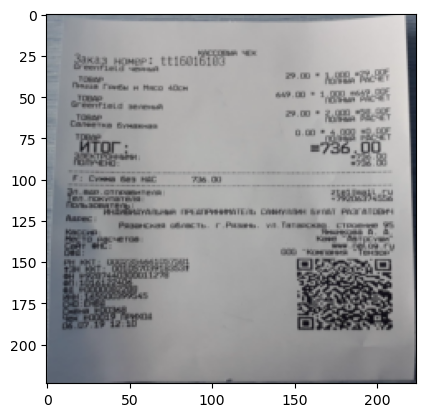

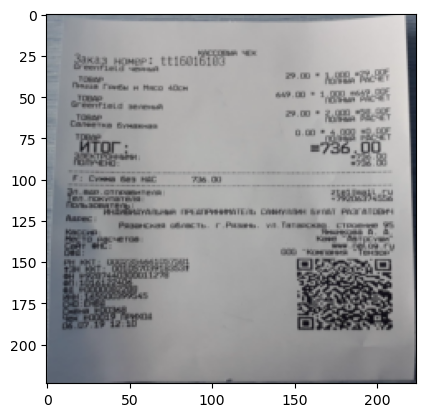

In [56]:
# testing my image processor

h, w, d = eval_dataset[0]['image_shape_h_w_d']
img = np.array(eval_dataset_after_prcsr[0]['image']).transpose(1, 2, 0)
plt.figure()
plt.imshow(img)

image_processor = LiteImageProcessor()
orig_image = np.array(eval_dataset[0]['image']).reshape(h, w, d)
img_resized = image_processor.preprocess(orig_image)
plt.figure()
plt.imshow(img_resized.reshape(224, 224, 3))